In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Random walk

Hamiltonian (general):

$\mathcal{H}=-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1;j \neq i}^{N}J_{\text{ij}}S_{\text{i}}S_{\text{j}}-B\sum_{i}S_{\text{i}}$

Hamiltonian (pairs of next neighbor interaction and equal interaction strength $J_{\text{ij}}=J$ ):

$\mathcal{H}=-J\sum_{<i,j>}^{N,N}S_{\text{i}}S_{\text{j}}-B\sum_{i}S_{\text{i}}$

Simple sampling observables:

$\langle Q \rangle = \frac{\sum_i Q_i \exp{(-\beta E_i)}}{\sum_i\exp{(-\beta E_i)}}$ mit $\beta = 1/k_\text{B}T$

In [73]:
class randomWalker:
    def __init__(self,L_ = 20,J_ = 1,B_ = 0):
        self.L = L_
        self.J = J_
        self.B = B_
        self.lattice = np.zeros((L_,L_),dtype=np.int)
        
    def randomize(self):
        # create new random array with -1 or 1
        self.lattice = (2*np.random.randint(2,size = self.lattice.shape))-1
    #

    def plotConfig(self):
        # plot the configs using a simple colormesh plot
        figure()
        pcolormesh(self.lattice)
        xlabel('Y')
        ylabel('X')
        title('Ising spin lattice')
        show()
    #
    
    def getMagnetisation(self):
        return float(self.lattice.sum())/self.lattice.size
    
    # care for periodic boundaries
    def foldBack(self, idx):
        if (idx < 0):
            return (self.L-1)
        elif (idx == self.L):
            return 0
        else:
            return idx
    
    # get single spin energy to be prepared for metropolis
    def getSingleSpinEnergy(self, x, y):
        sumSpins = self.lattice[x,self.foldBack(y+1)] + self.lattice[x,self.foldBack(y-1)] + self.lattice[self.foldBack(x+1),y] + self.lattice[self.foldBack(x-1),y]
        return -1.0 * self.lattice[x,y] * (self.J * sumSpins + self.B)
        
    # get total energy of the full lattice
    def getEnergy(self):
        E = 0
        for x in range(self.L):
            for y in range(self.L):
                E += self.getSingleSpinEnergy(x,y)
        # normalize total energy between -1 and +1
        return E/(2.0*self.lattice.size)
    
    # perform Metropolis move
    def performMCS(self, temperature, time):
        # introduce counter to check for frozen states
        counter = 0
        
        # check if lattice was initialised
        if self.lattice[0,0] == 0:
            self.randomize()
        
        # loop over number of timesteps
        for t in range(time):
            for i in range(self.L*self.L):
                # get random positions
                x = np.random.randint(0,self.L)
                y = np.random.randint(0,self.L)
                
                # get actuall spin energy
                e_old = self.getSingleSpinEnergy(x,y)
                # new energy is just with flipped spin -> -1
                e_new = -e_old
                # diff_energy=-2.0*self.getSingleSpinEnergy(x,y)
                # calculate probability from energy difference
                prob =np.exp( - (e_new - e_old) / temperature)
                
                # apply metropolis 
                if np.random.random_sample() < prob:
                    self.lattice[x,y] *= -1
                    counter += 1
        return counter
        

In [10]:
# make some test output
hugo = randomWalker(8)
hugo.randomize()
#hugo.plotConfig()
hugo.lattice[1,0]=1
hugo.lattice[0,3]=1
hugo.plotConfig()
print("size = ",hugo.L, "magnetisation = ", hugo.getMagnetisation())

print("spin energy of 0,0 = ",hugo.getSingleSpinEnergy(0,0))
print("total energy = ",hugo.getEnergy())


<IPython.core.display.Javascript object>

size =  8 magnetisation =  0.03125
spin energy of 0,0 =  1.0
total energy =  0.3125


In [12]:
# run the simulations of the simple sampling part
MyWalker = randomWalker(10)
# in beta =1/T ...
#temp = np.array([0.2,0.25,1/3,1/2.5,1/2.27,1/2.2,1/2.2,0.5,1,1.5,2,5,10])
temp = np.array([5,4,3,2.5,2.27,2.2,2.1,2,1.5,1,0.5,0.2])

meanM = np.zeros(temp.size)
meanE = np.zeros(temp.size)
normalization = np.zeros(temp.size)
hugo = randomWalker(20)
for n in range(10000):
    # get a new config
    MyWalker.randomize()
    # calculate unweighted magnetisation and energy
    E = MyWalker.getEnergy()
    M = MyWalker.getMagnetisation()
    # calculate boltzmann factor
    expE = np.exp(E/temp)
    # add weighted observables to means
    meanM += M*expE
    meanE += E*expE
    normalization += expE
    
print(meanM/normalization,"\n",meanE/normalization)

[-0.0007217  -0.00071711 -0.00070944 -0.00070329 -0.00069954 -0.00069824
 -0.00069623 -0.00069402 -0.00067844 -0.00064663 -0.00054354 -0.00012982] 
 [0.00316396 0.00413266 0.00574783 0.00704056 0.0078267  0.00809864
 0.00851861 0.00898065 0.01221688 0.0187     0.03824288 0.09799563]


<IPython.core.display.Javascript object>


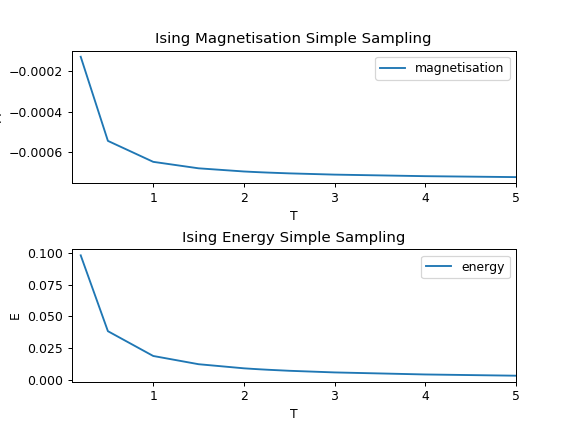

In [13]:
figure()

# subplot magnetisation
subplot(211)
plot(temp,meanM/normalization, label="magnetisation")
#plot(tempertatures,meanE/normalization, label="energy")
xlabel("T")
ylabel("M")
xlim(0.1,5)
legend(loc="best")
title("Ising Magnetisation Simple Sampling")

# subplot energy
subplot(212)
plot(temp,meanE/normalization, label="energy")
#plot(tempertatures,meanE/normalization, label="energy")
xlabel("T")
ylabel("E")
xlim(0.1,5)
legend(loc="best")
title("Ising Energy Simple Sampling")

# adjust plot spacing
subplots_adjust(hspace=.5)

show()

In [9]:
np.random.randint(0,MyWalker.L,MyWalker.L*MyWalker.L)

array([7, 4, 4, 4, 0, 5, 6, 2, 3, 3, 0, 3, 0, 5, 6, 4, 0, 6, 7, 9, 4, 9,
       1, 3, 2, 1, 7, 8, 9, 4, 0, 1, 9, 0, 1, 3, 6, 6, 0, 8, 9, 2, 9, 7,
       5, 0, 2, 8, 5, 0, 1, 6, 1, 8, 0, 3, 2, 1, 4, 6, 8, 3, 7, 2, 4, 5,
       3, 2, 6, 8, 0, 6, 5, 7, 2, 1, 2, 1, 2, 4, 7, 8, 3, 1, 0, 1, 9, 2,
       8, 3, 6, 8, 3, 7, 9, 7, 9, 3, 2, 9])

In [85]:
# define class instance
TheWalker = randomWalker(20)

# setup parameters
n_samples = 100
n_timesteps = 200
#temp = np.array([5,4,3,2.5,2.27,2.2,2.1,2,1.5,1,0.5,0.2])
# useful range between 1.5 and 3.0 as transistion is at T_C=2.27
myTemp = 1.5

# setup data container
data = np.zeros((n_samples,n_timesteps))

# run sime resolved simulations
for i in range(n_samples):
    TheWalker.randomize()
    for t in range(n_timesteps):
        check = TheWalker.performMCS(myTemp,1)
        #if (check):
        #    print("nothing moved")
        # use direct sampling without boltzmann weigth
        data[i,t] = TheWalker.getMagnetisation()
    # - if there are strange values, check some final configs for a few n_samples
    #TheWalker.plotConfig()
#

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


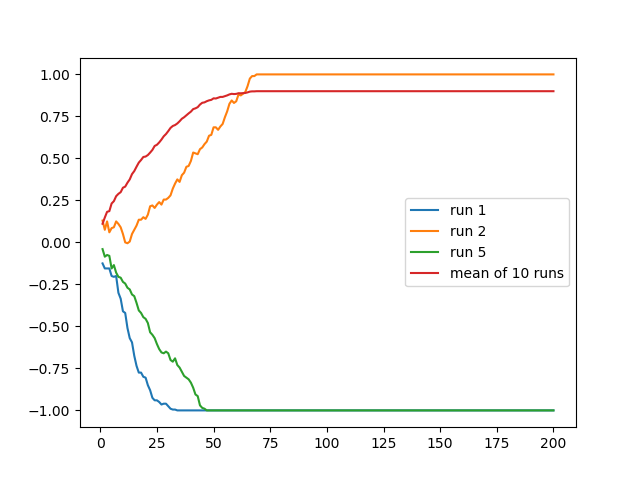

In [84]:
figure()
x = np.linspace(1,n_timesteps,n_timesteps)
plot(x,data[0,:], label= "run 1")
plot(x,data[1,:], label= "run 2")
plot(x,data[4,:], label= "run 5")
plot(x,np.sum(np.abs(data), axis = 0)/data.shape[0], label="mean of {} runs".format(data.shape[0]))
legend(loc="best")
show()

In [64]:
# run simulations for <M>, <E> and <C> = <E^2> - <E>^2

TheWalker = randomWalker(20)

temp = np.array([5,4,3,2.5,2.27,2.2,2.1,2,1.5,1,0.5,0.2])


array([0.04275, 0.055  , 0.069  , 0.08525, 0.0815 , 0.06125, 0.0495 ,
       0.059  , 0.06025, 0.07375, 0.08775, 0.08025, 0.06825, 0.091  ,
       0.09275, 0.08675, 0.05625, 0.0675 , 0.0685 , 0.06075, 0.06225,
       0.0585 , 0.06025, 0.06625, 0.0465 , 0.06125, 0.06225, 0.04875,
       0.06725, 0.06125, 0.07525, 0.0775 , 0.064  , 0.0765 , 0.085  ,
       0.077  , 0.0945 , 0.07225, 0.0795 , 0.053  , 0.05125, 0.07075,
       0.0685 , 0.074  , 0.083  , 0.07825, 0.07375, 0.0675 , 0.06975,
       0.073  , 0.06375, 0.0525 , 0.059  , 0.068  , 0.0585 , 0.05375,
       0.04825, 0.07425, 0.08075, 0.0615 , 0.07375, 0.06875, 0.08225,
       0.077  , 0.0605 , 0.085  , 0.06075, 0.07725, 0.08   , 0.07075,
       0.07025, 0.07325, 0.06825, 0.0675 , 0.0565 , 0.0675 , 0.074  ,
       0.08   , 0.0785 , 0.058  , 0.058  , 0.07325, 0.073  , 0.06225,
       0.063  , 0.068  , 0.0785 , 0.07125, 0.06925, 0.0725 , 0.06575,
       0.0805 , 0.086  , 0.09   , 0.08975, 0.0775 , 0.0755 , 0.0665 ,
       0.0545 , 0.04

In [63]:
data.shape

(20, 200)